# Multilevel Quantum Circuit Partitioning

This notebook explores the multilevel framework in some more depth and briefly comparese the different coarsening routines. This follows on from the "walkthrough" notebook.

In [30]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions, get_all_configs, get_all_costs
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.circuits.QAOA import QAOA_random
import numpy as np
import time
from disqco.graphs.quantum_network import QuantumNetwork

num_qubits = 16
num_partitions = 2
qpu_size = int(num_qubits / num_partitions) + 1
qpu_sizes = [qpu_size] * num_partitions

network = QuantumNetwork(qpu_sizes)


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()

graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network, num_qubits, depth, num_partitions)



The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


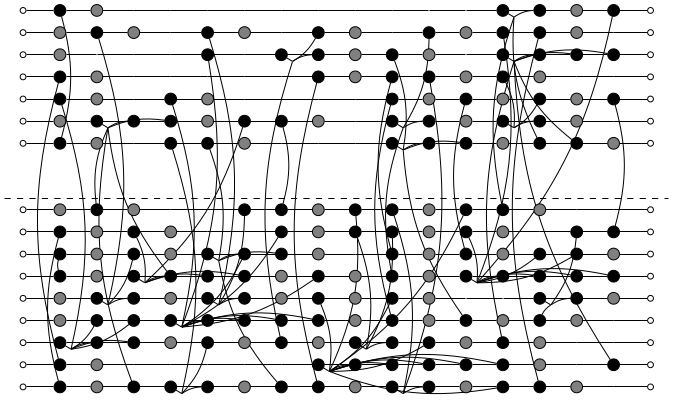

In [31]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

draw_graph_tikz(graph, assignment, qpu_sizes)

We first run the normal FM algorithm, with no coarsening, to set a benchmark. We will use the depth of the circuit to calculate the number of passes we will use, for fairness of comparison. We will set a limit on the number of nodes that can be moved per pass.

In [32]:
from disqco.parti.FM.FM_main import run_FM

level_limit = int(np.ceil(np.log2(depth))) + 2

num_passes = level_limit * 10
move_limit_per_pass = num_qubits * graph.depth * 0.125

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes,
    limit=move_limit_per_pass,
    passes=num_passes,
    log=True
)




Initial cost: 23
All passes complete.
Final cost: 14


In [ ]:
from disqco.parti.FM.multilevel_FM import *
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

# graph_list, mapping_list = coarsener.coarsen_full(graph, num_levels = depth)

# coarsest_graph = graph_list[-1]



We start by coarsening the graph down to a single time-step, to see how we well can do with static partitioning. The initialisation and termination nodes are included in the figure but are not part of the actual graph.

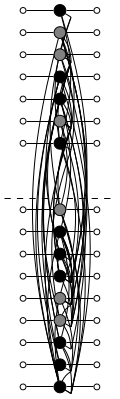

In [ ]:
# fig = draw_graph_tikz(
#     coarsest_graph,
#     assignment,
#     qpu_sizes
# )

# display(fig)

In [35]:
final_cost, final_assignment, cost_list = run_FM(coarsest_graph, assignment, qpu_sizes, limit=move_limit_per_pass, max_gain=4*depth, passes=num_passes, log=True)


Initial cost: 23
All passes complete.
Final cost: 13


In some cases, static partitioning can also do very well, but it will often be limited since no state teleportation is possible. We will now look at a multilevel approach using a window-based coarsening routine.

In [36]:
# graph_list_window, mapping_list_window = coarsener.coarsen_full(graph, num_levels = level_limit)

# for graph in graph_list_window:
#     fig = draw_graph_tikz(
#         graph,
#         assignment,
#         qpu_sizes
#     )
#     display(fig)

In [37]:
# graph_list_blocks, mapping_list_blocks= coarsener.coarsen_blocks(graph, num_blocks= None, block_size = level_limit)

# for graph in graph_list_blocks:
#     fig = draw_graph_tikz(
#         graph,
#         assignment,
#         qpu_sizes
#     )
#     display(fig)

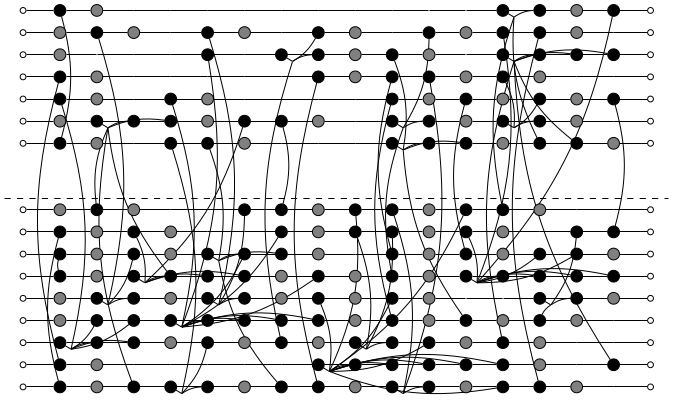

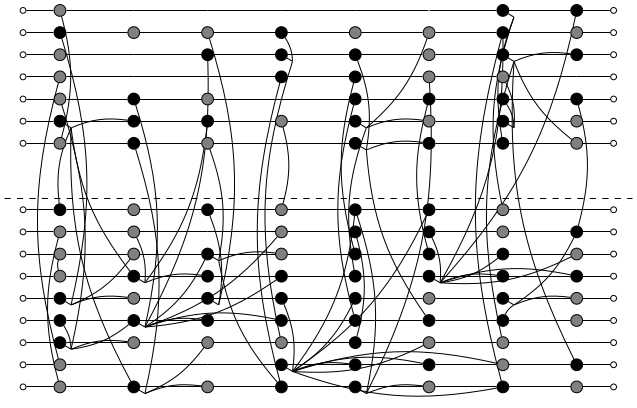

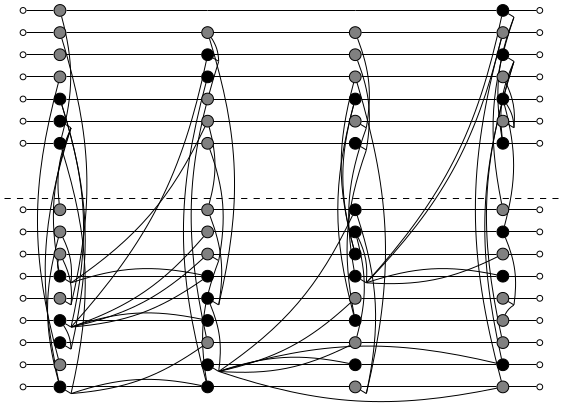

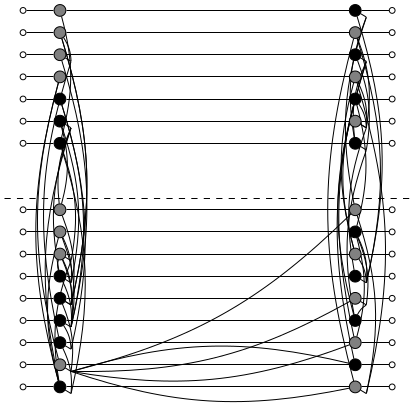

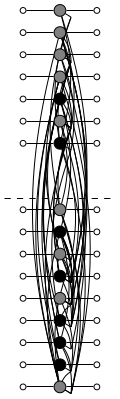

In [38]:
graph_list_recursive, mapping_list_recursive = coarsener.coarsen_recursive_batches(graph)

for graph in graph_list_recursive:
    fig = draw_graph_tikz(
        graph,
        assignment,
        qpu_sizes
    )
    display(fig)

In [39]:
from disqco.drawing.tikz_drawing import *
from disqco.drawing.mpl_drawing import *
assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
)

NameError: name 'assignment_list' is not defined

In [ ]:
num_qubits = 48
num_partitions = 6
qpu_size = int(num_qubits / num_partitions) + 1
qpu_info = [qpu_size] * num_partitions


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.9 )

# circuit = QFT(num_qubits, do_swaps=False)

# circuit = QuantumVolume(num_qubits, depth=num_qubits)

# circuit = QAOA_random(num_qubits, prob = 0.9, reps = 1)

# ansatz = EfficientSU2(num_qubits, entanglement='full', reps=1)

# param_values = np.random.rand(len(ansatz.parameters))
# param_dict = dict(zip(ansatz.parameters, param_values))
# circuit = ansatz.assign_parameters(param_dict)
cost_list_diag = []
cost_list_anti = []

for i in range(20):
    print("Iteration", i)
    circuit = transpile(circuit, basis_gates = ['cp', 'u'])

    depth = circuit.depth()

    graph = QuantumCircuitHyperGraph(circuit, group_gates=True)
    assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

    assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = None, 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = False,
                                        add_initial = False,
                                        costs = None)
    
    cost_list_diag.append(min(cost_list))

    graph = QuantumCircuitHyperGraph(num_qubits=num_qubits, depth=depth)
    graph.map_circuit_to_hypergraph(circuit, group_gates=True, anti_diag = True)
    assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)

    assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = None, 
                                        pass_list= None, 
                                        stochastic=True, 
                                        lock_nodes=False,
                                        log = False,
                                        add_initial = False,
                                        costs = None)

    cost_list_anti.append(min(cost_list))

    



Iteration 0


TypeError: QuantumCircuitHyperGraph.__init__() got an unexpected keyword argument 'num_qubits'

In [ ]:
print(np.mean(cost_list_diag))
print(np.mean(cost_list_anti))

284.8
282.4


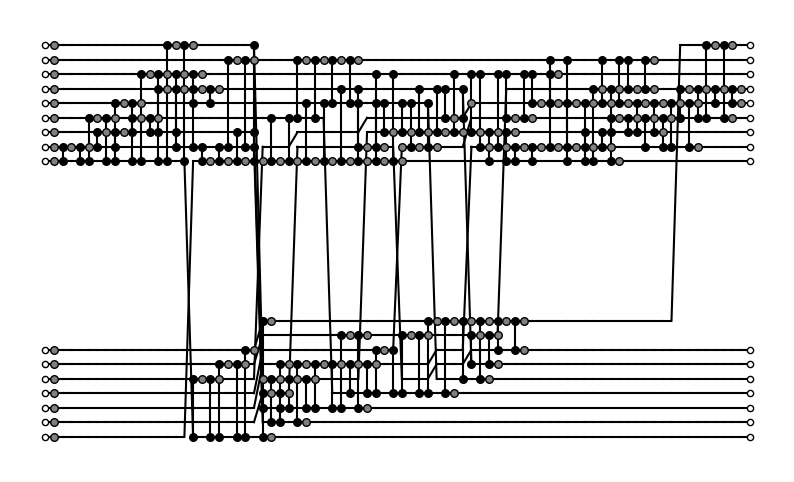

In [ ]:
from src.tikz_drawing import *
from src.mpl_drawing import *
assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    sum(qpu_info),
    xscale=15.0,
    yscale=25.0,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)